In [81]:
import numpy as np
import pandas as pd
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
#from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [82]:
country_to_predict="Somalia"

**ARIMA**


In [83]:
df=pd.read_excel('test_arima.xlsx')
df['Year']=pd.to_datetime(df.Year, format="%Y")
df=df[(df['Country']==country_to_predict)]
df.index.freq = 'YS'
df.head()

,Year,Value,Country
245,1970-01-01,40.957,Somalia
246,1971-01-01,41.342,Somalia
247,1972-01-01,41.727,Somalia
248,1973-01-01,42.111,Somalia
249,1974-01-01,42.494,Somalia


In [84]:
del df["Country"]

In [85]:
df['Year']=pd.to_datetime(df['Year'], format="%Y")
df=df.set_index(['Year'])
df.head()
df.index.freq = 'YS'

In [86]:
train_df = df[:len(df)-6]
test_df = df[len(df)-6:]

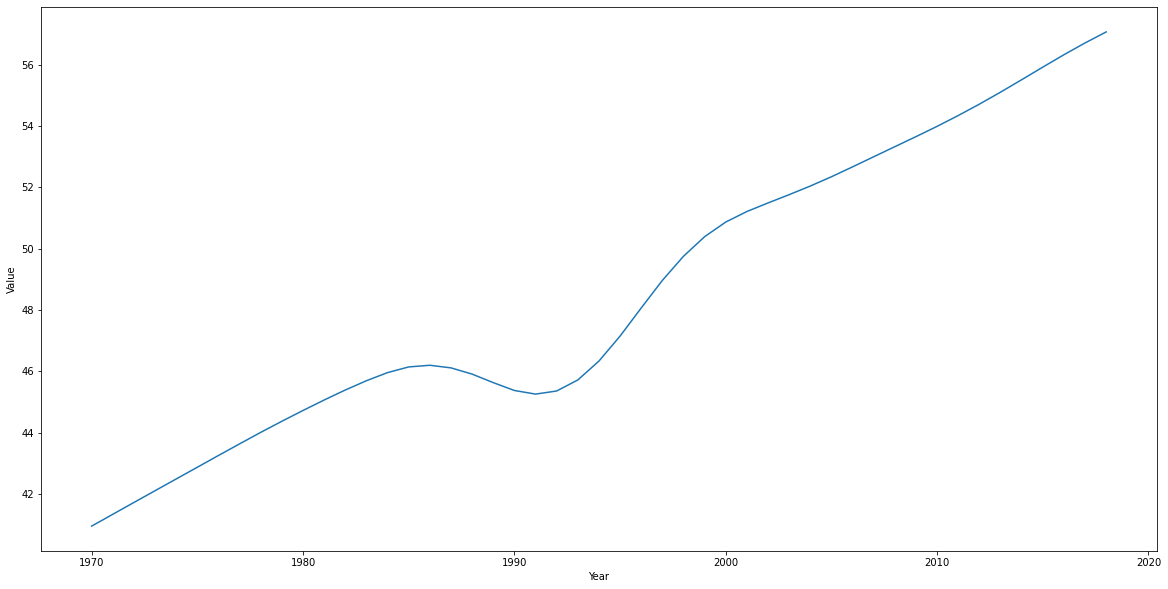

In [87]:
plt.figure(figsize=(20,10))
plt.xlabel("Year")
plt.ylabel("Value")
plt.plot(df)

In [88]:
rolmean=train_df.rolling(window=6).mean()
rolstd=train_df.rolling(window=6).std()
print(rolmean.head(15))
print(rolstd.head(15))

                Value
Year                 
1970-01-01        NaN
1971-01-01        NaN
1972-01-01        NaN
1973-01-01        NaN
1974-01-01        NaN
1975-01-01  41.917833
1976-01-01  42.301500
1977-01-01  42.684333
1978-01-01  43.065333
1979-01-01  43.442667
1980-01-01  43.814667
1981-01-01  44.180000
1982-01-01  44.535833
1983-01-01  44.878667
1984-01-01  45.203333
               Value
Year                
1970-01-01       NaN
1971-01-01       NaN
1972-01-01       NaN
1973-01-01       NaN
1974-01-01       NaN
1975-01-01  0.718132
1976-01-01  0.717063
1977-01-01  0.715513
1978-01-01  0.712417
1979-01-01  0.705391
1980-01-01  0.693478
1981-01-01  0.677273
1982-01-01  0.657168
1983-01-01  0.631794
1984-01-01  0.597567


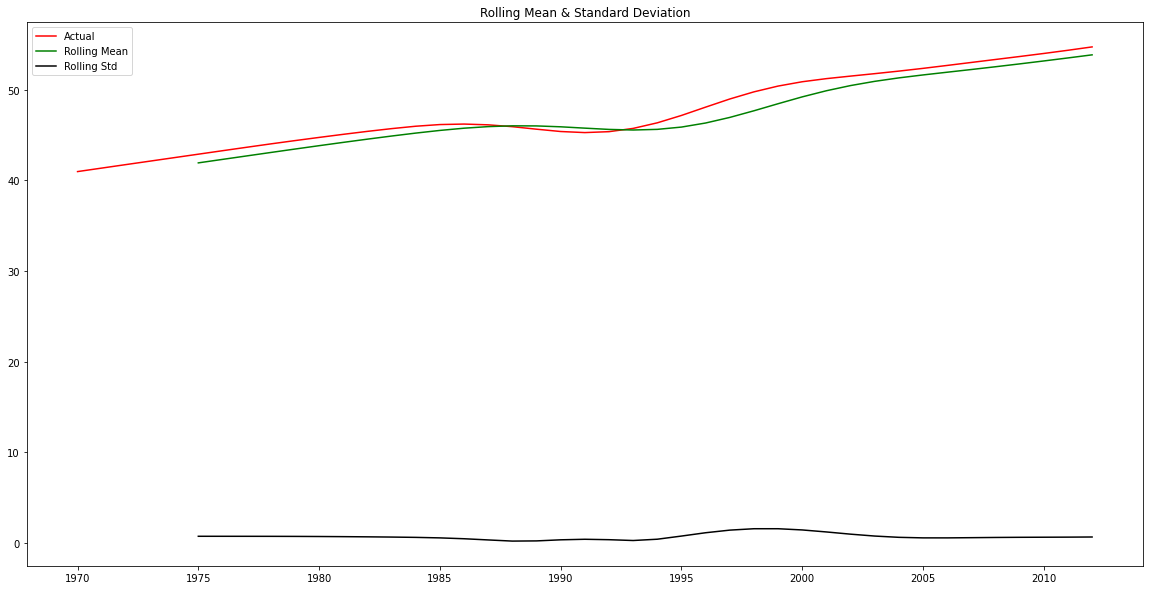

In [89]:
plt.figure(figsize=(20,10))
actual=plt.plot(train_df, color='red', label='Actual')
mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
std_6=plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [90]:
from statsmodels.tsa.stattools import adfuller
print('Dickey-Fuller Test: ')
dftest=adfuller(train_df['Value'], autolag='AIC')
dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Dickey-Fuller Test: 
Test Statistic           1.583519
p-value                  0.997807
Lags Used                6.000000
No. of Obs              36.000000
Critical Value (1%)     -3.626652
Critical Value (5%)     -2.945951
Critical Value (10%)    -2.611671
dtype: float64


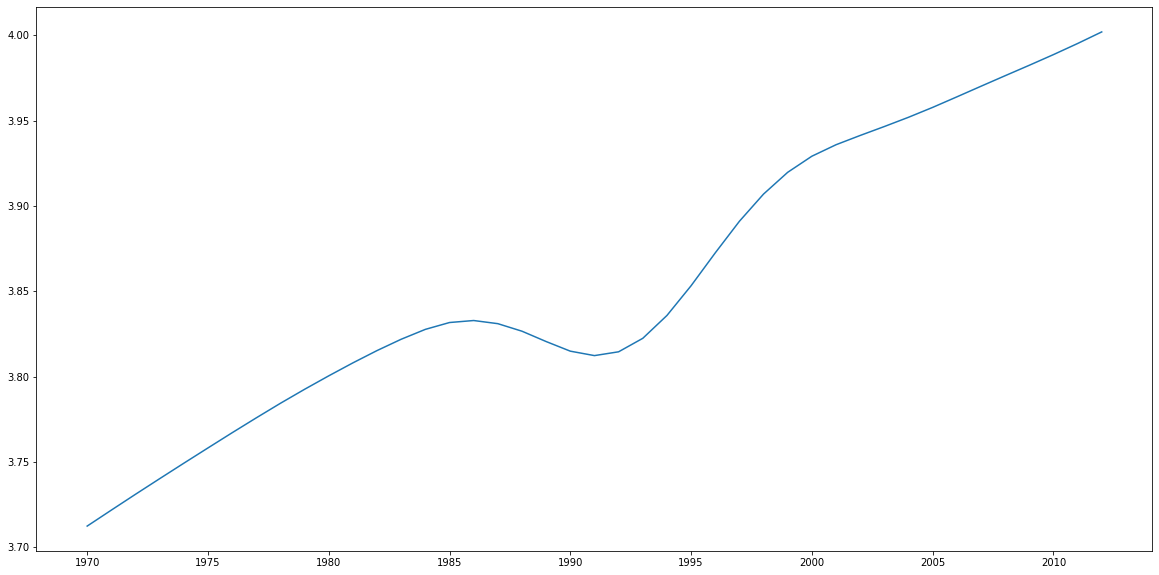

In [91]:
plt.figure(figsize=(20,10))
df_log=np.log(train_df)
plt.plot(df_log)

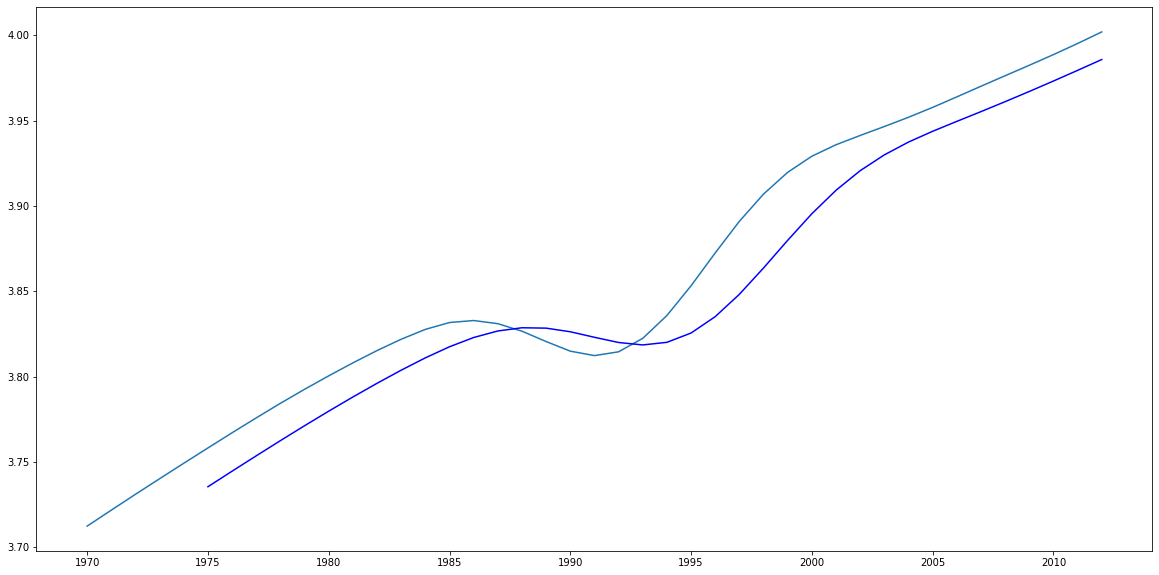

In [92]:
plt.figure(figsize=(20,10))
MAvg=df_log.rolling(window=6).mean()
MStd=df_log.rolling(window=6).std()
plt.plot(df_log)
plt.plot(MAvg, color='blue')

In [93]:
df_log_diff=df_log-MAvg
df_log_diff.head(12)

,Value
Year,
1970-01-01,NaN
1971-01-01,NaN
1972-01-01,NaN
1973-01-01,NaN
1974-01-01,NaN
1975-01-01,0.022723
1976-01-01,0.022503
1977-01-01,0.022236
1978-01-01,0.021881


In [94]:
df_log_diff=df_log_diff.dropna()
df_log_diff.head()

,Value
Year,
1975-01-01,0.022723
1976-01-01,0.022503
1977-01-01,0.022236
1978-01-01,0.021881
1979-01-01,0.021344


In [95]:
def stationarity(timeseries):
    
    rolmean=timeseries.rolling(window=6).mean()
    rolstd=timeseries.rolling(window=6).std()
    
    plt.figure(figsize=(20,10))
    actual=plt.plot(timeseries, color='red', label='Actual')
    mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
    std_6=plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Dickey-Fuller Test: ')
    dftest=adfuller(timeseries['Value'], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

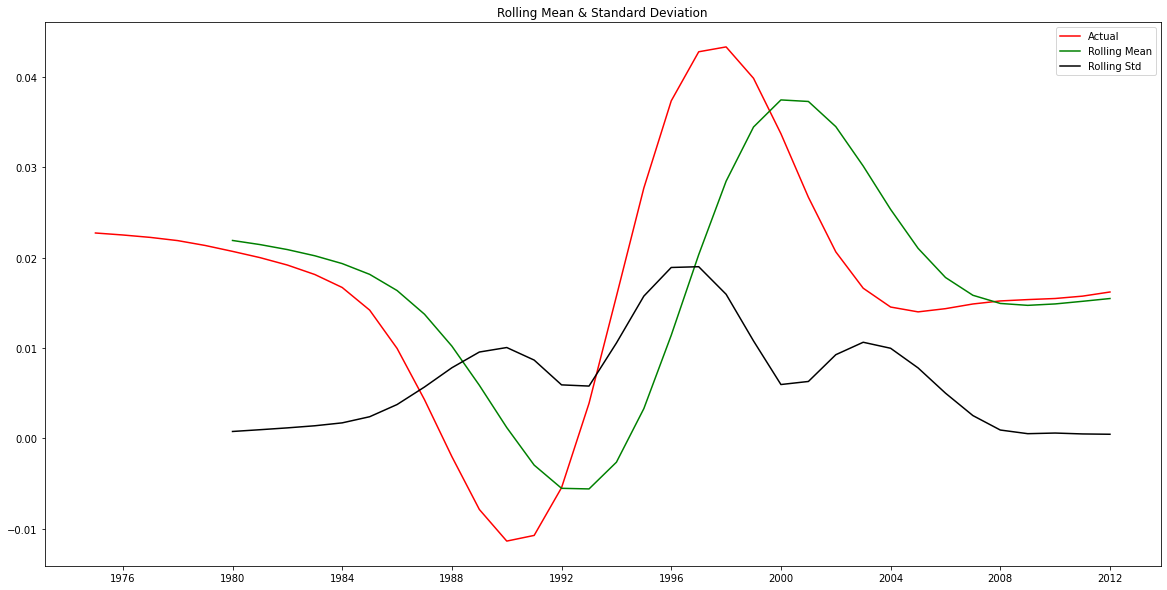

Dickey-Fuller Test: 
Test Statistic          -3.224679
p-value                  0.018600
Lags Used               10.000000
No. of Obs              27.000000
Critical Value (1%)     -3.699608
Critical Value (5%)     -2.976430
Critical Value (10%)    -2.627601
dtype: float64


In [96]:
stationarity(df_log_diff)

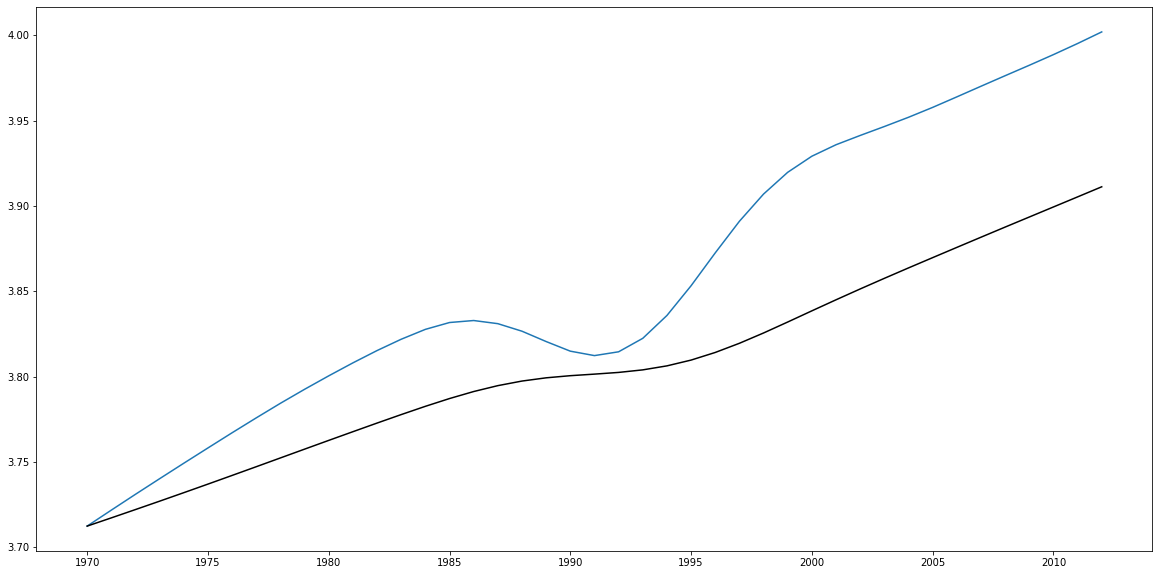

In [97]:
plt.figure(figsize=(20,10))
exp_df=df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(df_log)
plt.plot(exp_df, color='black')

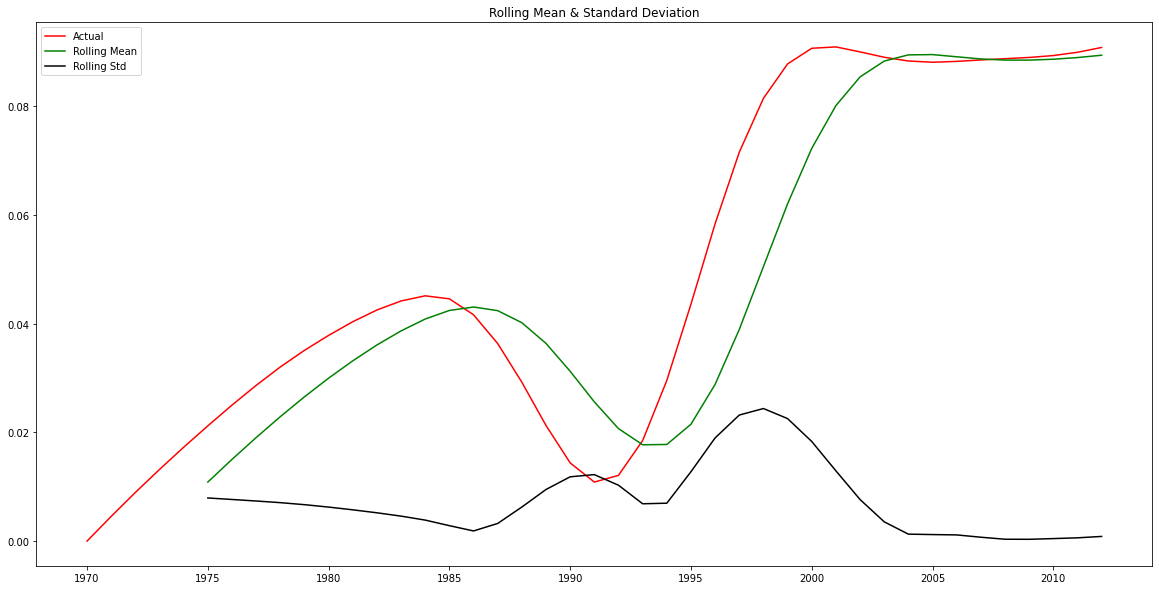

Dickey-Fuller Test: 
Test Statistic          -0.029812
p-value                  0.955996
Lags Used                6.000000
No. of Obs              36.000000
Critical Value (1%)     -3.626652
Critical Value (5%)     -2.945951
Critical Value (10%)    -2.611671
dtype: float64


In [98]:
exp_df_diff=df_log-exp_df
stationarity(exp_df_diff)

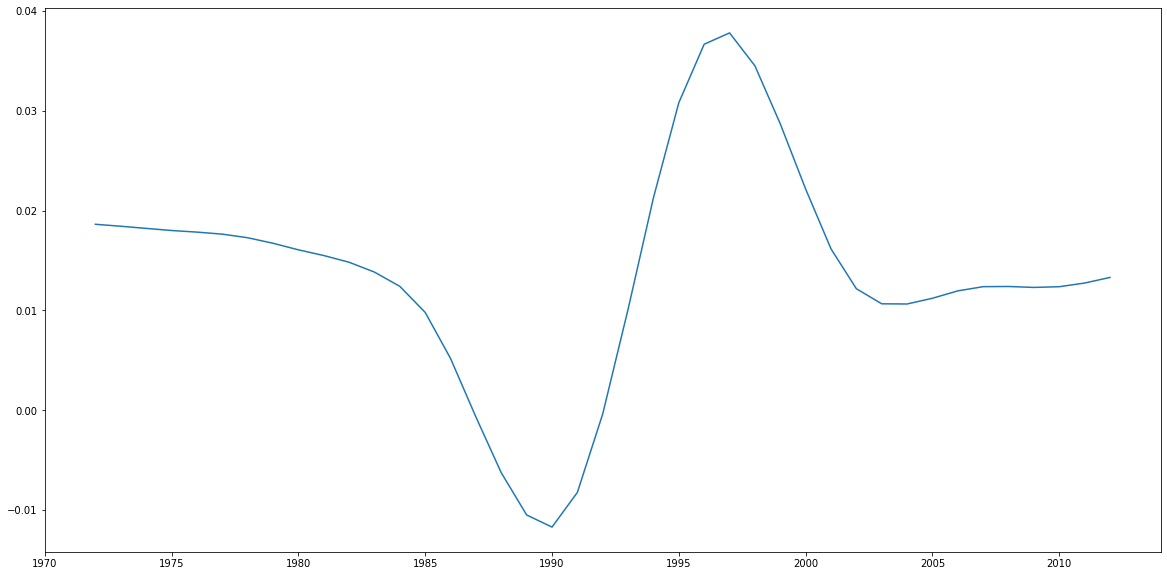

In [99]:
plt.figure(figsize=(20,10))
df_shift=df_log-df_log.shift(2)
plt.plot(df_shift)

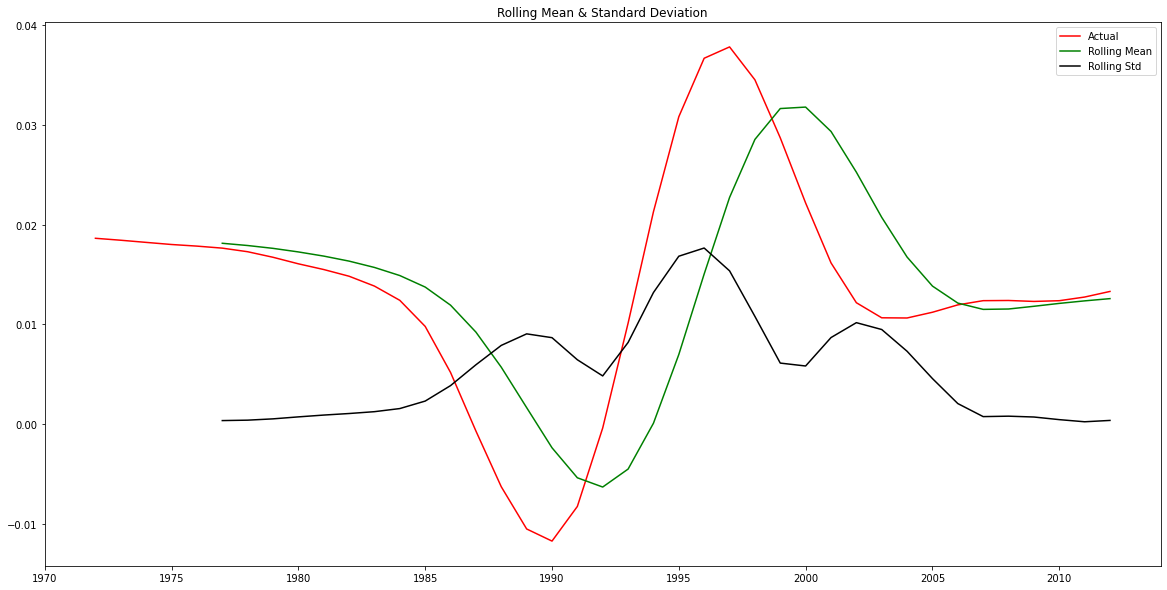

Dickey-Fuller Test: 
Test Statistic          -3.090927
p-value                  0.027232
Lags Used                9.000000
No. of Obs              31.000000
Critical Value (1%)     -3.661429
Critical Value (5%)     -2.960525
Critical Value (10%)    -2.619319
dtype: float64


In [100]:
df_shift=df_shift.dropna()
stationarity(df_shift)

Text(0.5, 1.0, 'Partial Autocorrelation Function')

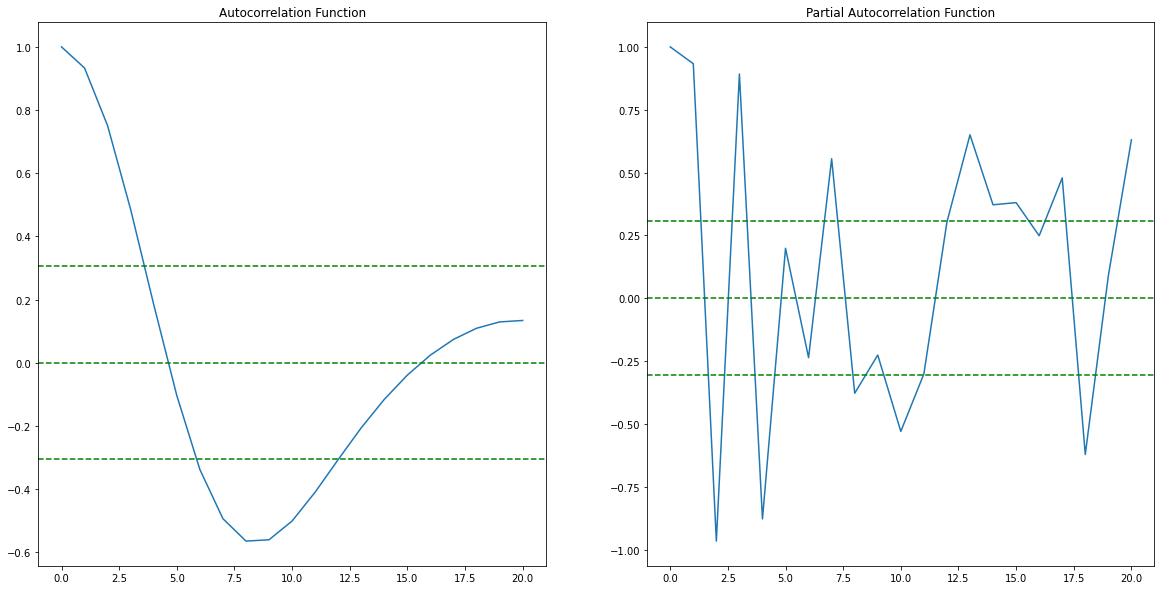

In [102]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf=acf(df_log_diff, nlags=20)
lag_pacf=pacf(df_log_diff, nlags=20, method='ols')

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.title('Partial Autocorrelation Function')

plotting ARIMA model


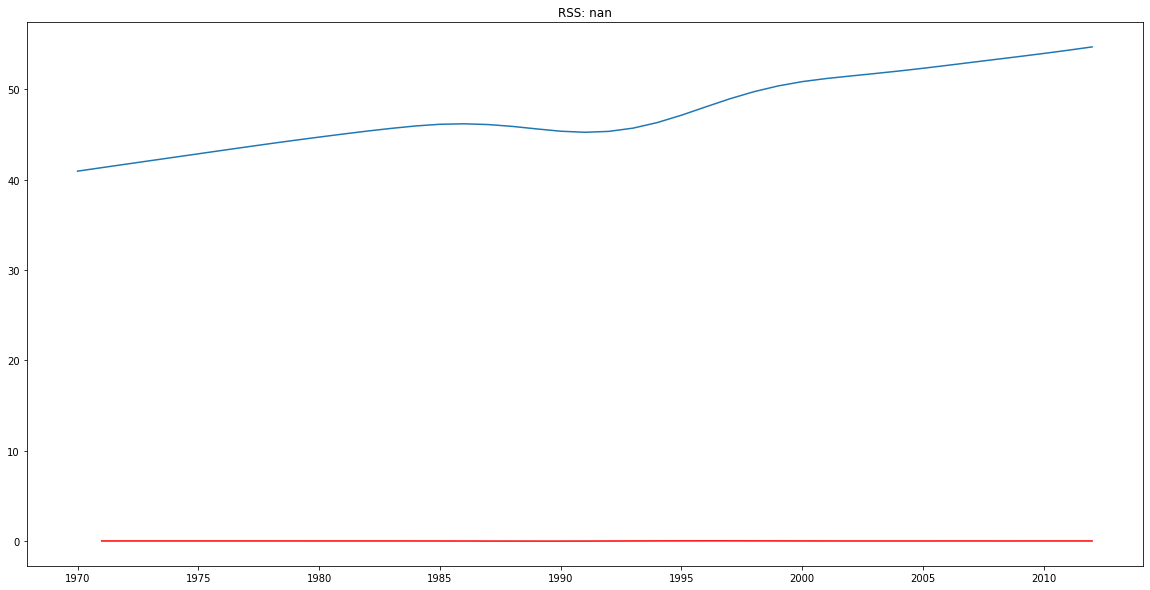

In [165]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize=(20,10))
model=ARIMA(df_log, order=(4,1,1))
results=model.fit(disp=-1)
plt.plot(train_df)
plt.plot(results.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results.fittedvalues-df_shift['Value'])**2))
print('plotting ARIMA model')

In [109]:
predictions=pd.Series(results.fittedvalues, copy=True)
print(predictions.head())

Year
1971-01-01    0.007031
1972-01-01    0.009200
1973-01-01    0.008892
1974-01-01    0.009003
1975-01-01    0.008899
Freq: AS-JAN, dtype: float64


In [110]:
predictions_cum_sum=predictions.cumsum()
print(predictions_cum_sum.head())

Year
1971-01-01    0.007031
1972-01-01    0.016231
1973-01-01    0.025123
1974-01-01    0.034126
1975-01-01    0.043025
Freq: AS-JAN, dtype: float64


In [111]:
predictions_log=pd.Series(df_log['Value'].iloc[0], index=df_log.index)
predictions_log=predictions_log.add(predictions_cum_sum,fill_value=0)
#predictions_log.head()

In [112]:
arima_pred = results.predict(start = len(train_df), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred=np.exp(arima_pred)
test_df['ARIMA_Predictions'] = arima_pred
#arima_pred


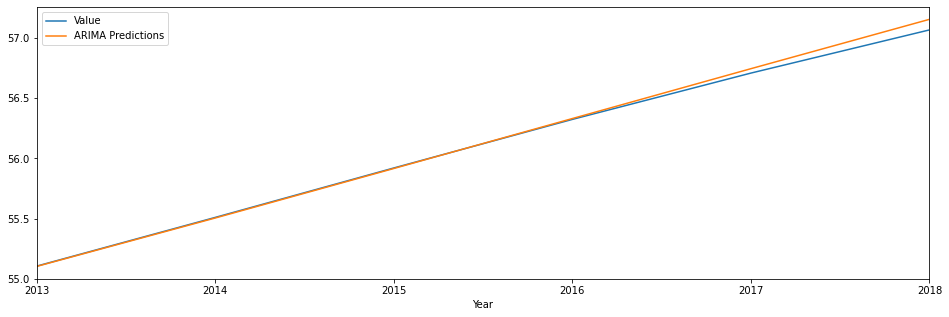

In [113]:
test_df['Value'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [114]:
arima_rmse_error = rmse(test_df['Value'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 0.0015271995963982632
RMSE Error: 0.039079401177580284
Mean: 48.53232653061225


In [115]:
output=results.forecast(13)
output1=np.exp(output[0])
output1
outputs = pd.DataFrame(output1[-7:])
outputs.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
outputs["Country"]=country_to_predict
outputs

,0,Country
2019,57.560840,Somalia
2020,57.960690,Somalia
2021,58.357412,Somalia
2022,58.753886,Somalia
2023,59.153265,Somalia
2024,59.558344,Somalia
2025,59.971069,Somalia


In [116]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_arima.xlsx')
writer = pandas.ExcelWriter('test_arima.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    outputs.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

In [117]:
test_df

,Value,ARIMA_Predictions
Year,,
2013-01-01,55.104,55.101579
2014-01-01,55.509,55.504130
2015-01-01,55.920,55.915710
2016-01-01,56.324,56.331049
2017-01-01,56.709,56.745528
2018-01-01,57.068,57.155928


**LSTM**

In [302]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [303]:
df=pd.read_excel('test_lstm.xlsx')
df['Year']=pd.to_datetime(df.Year, format="%Y")
df=df[(df['Country']==country_to_predict)]
del df["Country"]
df['Year']=pd.to_datetime(df['Year'], format="%Y")
df=df.set_index(['Year'])
df.index.freq = 'YS'
train_df_lstm = df[:len(df)-6]
test_df_lstm = df[len(df)-6:]
df.tail()

,Value
Year,
2014-01-01,55.509
2015-01-01,55.920
2016-01-01,56.324
2017-01-01,56.709
2018-01-01,57.068


In [304]:
scaler.fit(train_df)
scaled_train_data = scaler.transform(train_df_lstm)
scaled_test_data = scaler.transform(test_df_lstm)

In [305]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 6
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [306]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 64)                16896     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [307]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
37/37 [==============================] - 0s 3ms/step - loss: 0.1580
Epoch 2/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0209
Epoch 3/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 4/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 5/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 6/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 7/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 8/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 9/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 10/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 11/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 12/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 13/20
37/37 [==============================

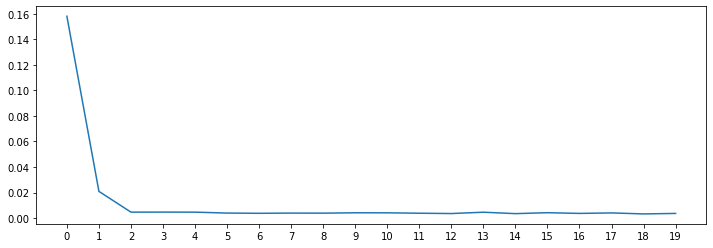

In [308]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [309]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_df)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [310]:
lstm_predictions_scaled

[array([1.0332634], dtype=float32),
 array([1.0646796], dtype=float32),
 array([1.0981703], dtype=float32),
 array([1.134073], dtype=float32),
 array([1.1726301], dtype=float32),
 array([1.2143843], dtype=float32)]

In [311]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [312]:
lstm_predictions

array([[55.17057195],
       [55.60273289],
       [56.06343038],
       [56.55730845],
       [57.08769927],
       [57.66207067]])

In [313]:
test_df['LSTM_Predictions'] = lstm_predictions

In [314]:
test_df

,Value,ARIMA_Predictions,LSTM_Predictions
Year,,,
2013-01-01,55.104,55.101579,55.170572
2014-01-01,55.509,55.504130,55.602733
2015-01-01,55.920,55.915710,56.063430
2016-01-01,56.324,56.331049,56.557308
2017-01-01,56.709,56.745528,57.087699
2018-01-01,57.068,57.155928,57.662071


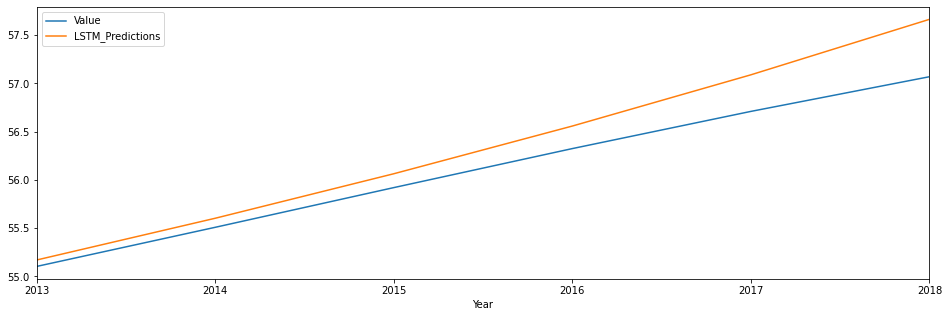

In [315]:
test_df['Value'].plot(figsize = (16,5), legend=True)
test_df['LSTM_Predictions'].plot(legend = True);

In [316]:
lstm_rmse_error = rmse(test_df['Value'], test_df["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 0.09742597993436268
RMSE Error: 0.3121313504509963
Mean: 48.53232653061225


In [317]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_df)+6):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [318]:
lstm_predictions_scaled

[array([1.0332634], dtype=float32),
 array([1.0646796], dtype=float32),
 array([1.0981703], dtype=float32),
 array([1.134073], dtype=float32),
 array([1.1726301], dtype=float32),
 array([1.2143843], dtype=float32),
 array([1.2599175], dtype=float32),
 array([1.309072], dtype=float32),
 array([1.3630533], dtype=float32),
 array([1.4228063], dtype=float32),
 array([1.4894569], dtype=float32),
 array([1.5644631], dtype=float32)]

In [319]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [320]:
lstm_predictions

array([[55.17057195],
       [55.60273289],
       [56.06343038],
       [56.55730845],
       [57.08769927],
       [57.66207067],
       [58.2884251 ],
       [58.96459468],
       [59.7071615 ],
       [60.52912295],
       [61.44596901],
       [62.47775493]])

In [321]:
output2=lstm_predictions
outputs2 = pd.DataFrame(lstm_predictions[-7:])
outputs2.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
outputs2["Country"]=country_to_predict
outputs2

,0,Country
2019,57.662071,Somalia
2020,58.288425,Somalia
2021,58.964595,Somalia
2022,59.707161,Somalia
2023,60.529123,Somalia
2024,61.445969,Somalia
2025,62.477755,Somalia


In [322]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_lstm.xlsx')
writer = pandas.ExcelWriter('test_lstm.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    outputs2.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

**Prophet**

In [323]:
df = pd.read_excel('test_prophet.xlsx')
df=df[(df['Country']==country_to_predict)]
del df["Country"]
df.head()
df_pr = df.copy()
#df = df.reset_index()
df_pr.columns = ['ds','y']
df_pr.tail()


,ds,y
289,2014,55.509
290,2015,55.920
291,2016,56.324
292,2017,56.709
293,2018,57.068


In [324]:
df_pr['ds'] = pd.to_datetime(df_pr['ds'],format="%Y")
df_pr.tail()

,ds,y
289,2014-01-01,55.509
290,2015-01-01,55.920
291,2016-01-01,56.324
292,2017-01-01,56.709
293,2018-01-01,57.068


In [325]:
train_data_pr = df_pr.iloc[:len(df)-6]
test_data_pr = df_pr.iloc[len(df)-6:]

In [326]:
from fbprophet import Prophet

In [327]:
m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=6,freq='YS')
prophet_pred = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [328]:
prophet_pred.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
44,2014-01-01,16.902987,55.131799,55.481488,16.739633,17.074413,38.400171,38.400171,38.400171,38.400171,38.400171,38.400171,0.0,0.0,0.0,55.303158
45,2015-01-01,17.229777,55.299218,56.028607,16.888558,17.619960,38.409066,38.409066,38.409066,38.409066,38.409066,38.409066,0.0,0.0,0.0,55.638843
46,2016-01-01,17.556568,55.421218,56.592212,16.999447,18.178163,38.421116,38.421116,38.421116,38.421116,38.421116,38.421116,0.0,0.0,0.0,55.977684
47,2017-01-01,17.884253,55.460747,57.163298,17.068447,18.759597,38.397744,38.397744,38.397744,38.397744,38.397744,38.397744,0.0,0.0,0.0,56.281997
48,2018-01-01,18.211043,55.516424,57.802809,17.122926,19.398896,38.400171,38.400171,38.400171,38.400171,38.400171,38.400171,0.0,0.0,0.0,56.611214


In [329]:
prophet_pred = pd.DataFrame({"Year" : prophet_pred[-6:]['ds'], "Pred" : prophet_pred[-6:]["yhat"]})

In [330]:
prophet_pred = prophet_pred.set_index("Year")

In [331]:
prophet_pred.index.freq = "YS"

In [332]:
prophet_pred

,Pred
Year,
2013-01-01,54.973941
2014-01-01,55.303158
2015-01-01,55.638843
2016-01-01,55.977684
2017-01-01,56.281997
2018-01-01,56.611214


In [333]:
test_df["Prophet_Predictions"] = prophet_pred['Pred'].values
test_df

,Value,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions
Year,,,,
2013-01-01,55.104,55.101579,55.170572,54.973941
2014-01-01,55.509,55.504130,55.602733,55.303158
2015-01-01,55.920,55.915710,56.063430,55.638843
2016-01-01,56.324,56.331049,56.557308,55.977684
2017-01-01,56.709,56.745528,57.087699,56.281997
2018-01-01,57.068,57.155928,57.662071,56.611214


In [334]:
import seaborn as sns

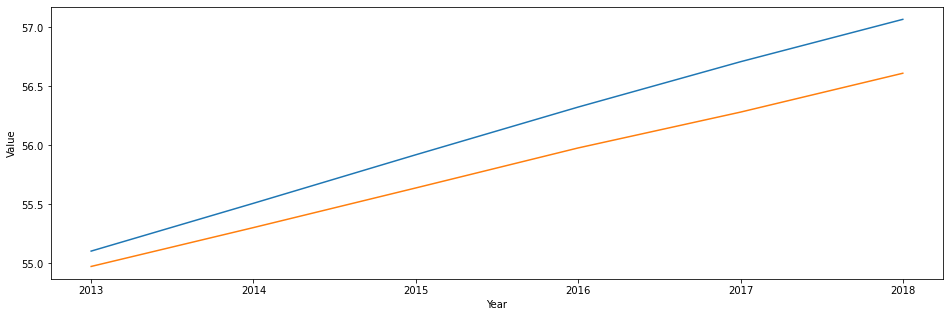

In [335]:
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_df.index, y=test_df["Value"])
sns.lineplot(x=test_df.index, y = test_df["Prophet_Predictions"]);

In [336]:
prophet_rmse_error = rmse(test_df['Value'], test_df["Prophet_Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

MSE Error: 0.10820923736231212
RMSE Error: 0.32895172497239183
Mean: 48.53232653061225


In [337]:
future = m.make_future_dataframe(periods=13,freq = 'YS')
prophet_pred = m.predict(future)

In [338]:
#prophet_pred = pd.DataFrame({"Year" : prophet_pred[-11:]['ds'], "Pred" : prophet_pred[-11:]["yhat"]})
abc=prophet_pred[['ds', 'yhat']].tail(7)

In [339]:
abc.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
del abc['ds']
abc = abc.rename(columns={'yhat': 'Value'})
abc["Country"]=country_to_predict
abc

,Value,Country
2019,56.946899,Somalia
2020,57.285740,Somalia
2021,57.590053,Somalia
2022,57.919270,Somalia
2023,58.254955,Somalia
2024,58.593796,Somalia
2025,58.898108,Somalia


In [340]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_prophet.xlsx')
writer = pandas.ExcelWriter('test_prophet.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    abc.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

In [341]:
rmse_errors = [arima_rmse_error, lstm_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})

Mean: 56.10566666666667


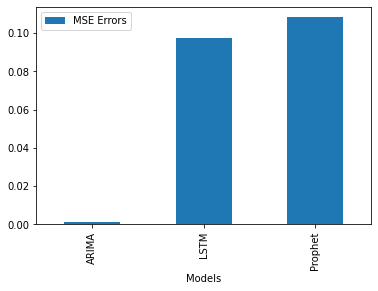

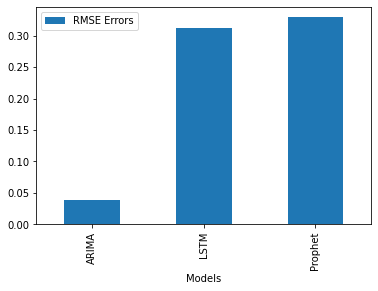

In [342]:
print(f"Mean: {test_df['Value'].mean()}")
errors
errors.plot(kind="bar",x="Models",y="MSE Errors")
errors.plot(kind="bar",x="Models",y="RMSE Errors")

In [343]:
errors["Country"]=country_to_predict
errors

,Models,RMSE Errors,MSE Errors,Country
0,ARIMA,0.039079,0.001527,Somalia
1,LSTM,0.312131,0.097426,Somalia
2,Prophet,0.328952,0.108209,Somalia


In [344]:
import pandas
from openpyxl import load_workbook

book = load_workbook('errors.xlsx')
writer = pandas.ExcelWriter('errors.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    errors.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index =False,header= False)

writer.save()

In [345]:
output3=test_df
output3["Country"]=country_to_predict
output3.reset_index()
output3.index=['2013', '2014', '2015','2016', '2017', '2018']
output3

,Value,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions,Country
2013,55.104,55.101579,55.170572,54.973941,Somalia
2014,55.509,55.504130,55.602733,55.303158,Somalia
2015,55.920,55.915710,56.063430,55.638843,Somalia
2016,56.324,56.331049,56.557308,55.977684,Somalia
2017,56.709,56.745528,57.087699,56.281997,Somalia
2018,57.068,57.155928,57.662071,56.611214,Somalia


In [346]:
import pandas
from openpyxl import load_workbook

book = load_workbook('comparison.xlsx')
writer = pandas.ExcelWriter('comparison.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    output3.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index =True,header= False)

writer.save()

<Figure size 1368x648 with 0 Axes>

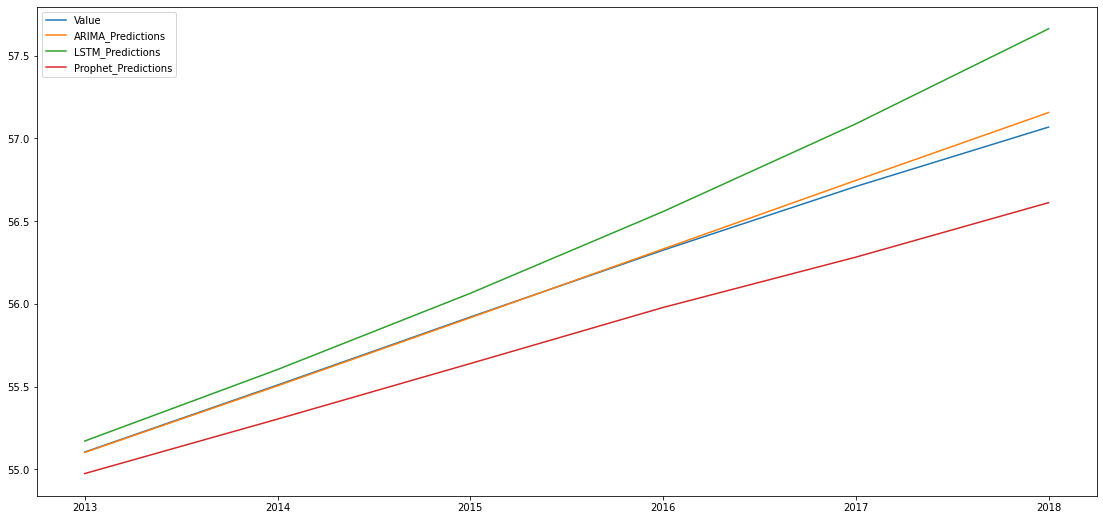

In [347]:
plt.figure(figsize=(19,9))
test_df.plot(figsize=(19,9))